# Abusif content classification

In [1]:
# import libraries 
import pandas as pd
# pd take screen width
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
%matplotlib inline


In [2]:
arabic_stopwords = set(nltk.corpus.stopwords.words("arabic"))

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations = arabic_punctuations + english_punctuations


def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text


def remove_emails(text):
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "",  text, flags=re.MULTILINE)
    return text

# def remove_emoji(text):
#     return emoji.get_emoji_regexp().sub(u'', text)

def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

#elongation
def normalization(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_stopwords(text):
    filtered_sentence = [w for w in text.split() if not w in arabic_stopwords]
    return ' '.join(filtered_sentence)

#cleaning function
def cleaning_content(line):
    if (isinstance(line, float)):
        return None
    line.replace('\n', ' ')
    line = remove_emails(line)
    line = remove_urls(line)
    line = remove_emoji(line)
    nline = [w if '@' not in w else 'USERID' for w in line.split()]
    line = ' '.join(nline)
    line = line.replace('RT', '').replace('<LF>', '').replace('<br />','').replace('&quot;', '').replace('<url>', '').replace('USERID', '')


    # add spaces between punc,
    line = line.translate(str.maketrans({key: " {0} ".format(key) for key in punctuations}))

    # then remove punc,
    translator = str.maketrans('', '', punctuations)
    line = line.translate(translator)

    line = remove_stopwords(line)
    line=remove_diacritics(normalization(line))
    return line

def hasDigits(s):
    return any( 48 <= ord(char) <= 57  or 1632 <= ord(char) <= 1641 for char in s)


In [3]:
# read the data
annotated_data = pd.read_csv('/kaggle/input/offensive-dataset/final_manually_annotated.csv')
#scrapped_data = pd.read_csv('/kaggle/input/offensive-content/final_dataset.csv', encoding='utf-16')

annotated_data

,text,label
0,البطل قاتل وجاذف بحياته لتحيا انت واطي عيب الشوم,Verbal abuse
1,انو غريب يوجعك راسك القواتجيه عاده بيكونو بلا راس,Racism
2,طاءفي روح اسال اهل قانا وهني بخبروك,Racism
3,غرد الجحش وظن باءنه حصانا تتكلم العوني بموضوعيه فيرد كبهيم حقير جربان اصله,Verbal abuse
4,الفلسطينيين واللبنانين والشاميين لكان انتو لليوم تشربوا بول البعير تاكلون بصحن وتبزقون منو,Racism
...,...,...
2486,اله اينعل ربك,religion_off
2487,شيطان,religion_off
2488,يهودي،,religion_off
2489,تا فينو الله؟؟! - الإلحاد,religion_off


In [4]:
# drop nan values
annotated_data.dropna(inplace=True)
print( f" length of annotated_data : {len(annotated_data)}")
annotated_data['label'].value_counts()

 length of annotated_data : 2490


Verbal abuse     1136
not offensive     767
religion_off      311
Racism            177
Misogyny           99
Name: label, dtype: int64

In [5]:
# select label racism
abusif = annotated_data[annotated_data['label'] == 'Verbal abuse']
display(abusif)
# delete label racism from df
not_abusif = annotated_data[annotated_data['label'] != 'Verbal abuse']
display(not_abusif)
not_abusif = not_abusif.iloc[:1136]
display(not_abusif)
# concat abusif and df
data = pd.concat([not_abusif, abusif])
# rename label diffrent than abusif to 'not abusif'
data['label'] = data['label'].apply(lambda x: 'not abusif' if x != 'Verbal abuse' else x)
data


,text,label
0,البطل قاتل وجاذف بحياته لتحيا انت واطي عيب الشوم,Verbal abuse
3,غرد الجحش وظن باءنه حصانا تتكلم العوني بموضوعيه فيرد كبهيم حقير جربان اصله,Verbal abuse
5,رايه يوسف علاونه ربي اغفر واعرف انك تغفر اقترح ان نعرض امك طبيب بيطري لنشوف اي جحش ابوك,Verbal abuse
6,والله وصاير شعراوي واوي بعرفك حمار بتحكي كلمتين حافظن لتسب العالم,Verbal abuse
8,كول هوا,Verbal abuse
...,...,...
2447,مرتزق وبتفلسف ؟. ليس في الحكومه ولا حزب وغبر معروف غريب عابش على التسول.تعال صنعا اذا تريد فلوس.,Verbal abuse
2449,بوزبال,Verbal abuse
2454,@User.IDX كذب يا خنزيرة حسبي الله ونعم الوكيل فيكم اللهم احفظ مصر من شركم تحيا مصر رغم انف الحاقدين ✌,Verbal abuse
2455,الناس غادين معاه بنيتهم وهو شلاهبي ولكين الحق غادي يبان,Verbal abuse


,text,label
1,انو غريب يوجعك راسك القواتجيه عاده بيكونو بلا راس,Racism
2,طاءفي روح اسال اهل قانا وهني بخبروك,Racism
4,الفلسطينيين واللبنانين والشاميين لكان انتو لليوم تشربوا بول البعير تاكلون بصحن وتبزقون منو,Racism
7,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,not offensive
9,هيدي مش وزيره هيدي شيطان الحكومه عاملي ال عمليه تجميل وبعدا بشعه محلا المسخ,Misogyny
...,...,...
2486,اله اينعل ربك,religion_off
2487,شيطان,religion_off
2488,يهودي،,religion_off
2489,تا فينو الله؟؟! - الإلحاد,religion_off


,text,label
1,انو غريب يوجعك راسك القواتجيه عاده بيكونو بلا راس,Racism
2,طاءفي روح اسال اهل قانا وهني بخبروك,Racism
4,الفلسطينيين واللبنانين والشاميين لكان انتو لليوم تشربوا بول البعير تاكلون بصحن وتبزقون منو,Racism
7,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,not offensive
9,هيدي مش وزيره هيدي شيطان الحكومه عاملي ال عمليه تجميل وبعدا بشعه محلا المسخ,Misogyny
...,...,...
2171,"حينما يكف الشيعة عن ترديد ""لبيك يا حسين"" و السنة عن ترديد ""لبيك يا محمد"" ويبداء الطرفين بترديد ""لبيك يا عراق"" فسنبداء مشوار التحرر",not offensive
2172,حيت وجهك خايب بزاف، عليها عرتي مؤ خرتك، ولكن الزين كيحشم عل زينو.,Misogyny
2173,انا هادي عجبتني فيها شوف تيفي... وايني محامي مطور.... زعمه راك راجل قانون.... انا مع لبنت ليلى و مع أي مرأة كوني ام... بحال هاد رجال خاصهم إعدام... بكل احتراماتي لي رجال الي عندهم خوف من الله على بنات ناس. تحياتي ليكم,not offensive
2175,نعم خونة وعملاءوموتىبغيظك وعملاء السعودية,Racism


,text,label
1,انو غريب يوجعك راسك القواتجيه عاده بيكونو بلا راس,not abusif
2,طاءفي روح اسال اهل قانا وهني بخبروك,not abusif
4,الفلسطينيين واللبنانين والشاميين لكان انتو لليوم تشربوا بول البعير تاكلون بصحن وتبزقون منو,not abusif
7,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,not abusif
9,هيدي مش وزيره هيدي شيطان الحكومه عاملي ال عمليه تجميل وبعدا بشعه محلا المسخ,not abusif
...,...,...
2447,مرتزق وبتفلسف ؟. ليس في الحكومه ولا حزب وغبر معروف غريب عابش على التسول.تعال صنعا اذا تريد فلوس.,Verbal abuse
2449,بوزبال,Verbal abuse
2454,@User.IDX كذب يا خنزيرة حسبي الله ونعم الوكيل فيكم اللهم احفظ مصر من شركم تحيا مصر رغم انف الحاقدين ✌,Verbal abuse
2455,الناس غادين معاه بنيتهم وهو شلاهبي ولكين الحق غادي يبان,Verbal abuse


In [6]:
# clean the data
data['text'] = data['text'].apply(cleaning_content)
print(data['label'].value_counts())
data

not abusif      1136
Verbal abuse    1136
Name: label, dtype: int64


,text,label
1,انو غريب يوجعك راسك القواتجيه عاده بيكونو بلا راس,not abusif
2,طاءفي روح اسال اهل قانا وهني بخبروك,not abusif
4,الفلسطينيين واللبنانين والشاميين لكان انتو لليوم تشربوا بول البعير تاكلون بصحن وتبزقون منو,not abusif
7,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,not abusif
9,هيدي مش وزيره هيدي شيطان الحكومه عاملي ال عمليه تجميل وبعدا بشعه محلا المسخ,not abusif
...,...,...
2447,مرتزق وبتفلسف الحكومه حزب وغبر معروف غريب عابش التسول تعال صنعا اذا تريد فلوس,Verbal abuse
2449,بوزبال,Verbal abuse
2454,كذب خنزيره حسبي الله ونعم الوكيل فيكم اللهم احفظ مصر شركم تحيا مصر رغم انف الحاقدين,Verbal abuse
2455,الناس غادين معاه بنيتهم شلاهبي ولكين الحق غادي يبان,Verbal abuse


In [7]:
data.label.unique()

array(['not abusif', 'Verbal abuse'], dtype=object)

              precision    recall  f1-score   support

Verbal abuse       0.71      0.78      0.74       220
  not abusif       0.77      0.71      0.74       235

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455



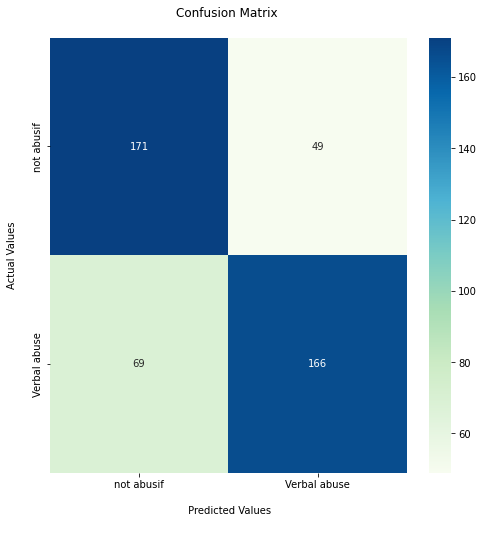

In [8]:
# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# vectorize the data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# train the model
from sklearn.naive_bayes import MultinomialNB

MNB_model = MultinomialNB().fit(X_train, y_train)

# test the model
predicted_mnb = MNB_model.predict(X_test)

# evaluate the model
from sklearn import metrics
print(metrics.classification_report(y_test, predicted_mnb))
probs_mnb = MNB_model.predict_proba(X_test)

#confusion matrix
plt.figure(figsize=(8,8))
fx=sns.heatmap(metrics.confusion_matrix(y_test, predicted_mnb), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'].unique())
fx.yaxis.set_ticklabels(data['label'].unique())
plt.show()



In [9]:
for i in range(len(probs_mnb)):
    print(predicted_mnb[i], probs_mnb[i],y_test.iloc[i])

not abusif [0.33610636 0.66389364] not abusif
not abusif [0.43707223 0.56292777] Verbal abuse
Verbal abuse [0.672988 0.327012] Verbal abuse
not abusif [0.45909917 0.54090083] not abusif
Verbal abuse [0.57328964 0.42671036] Verbal abuse
Verbal abuse [0.61505167 0.38494833] not abusif
not abusif [0.17277023 0.82722977] not abusif
not abusif [0.3047325 0.6952675] not abusif
not abusif [0.25161346 0.74838654] not abusif
not abusif [0.40367594 0.59632406] not abusif
not abusif [0.42840712 0.57159288] not abusif
Verbal abuse [0.6563975 0.3436025] Verbal abuse
Verbal abuse [0.68687765 0.31312235] Verbal abuse
not abusif [0.45264579 0.54735421] not abusif
not abusif [0.36777589 0.63222411] not abusif
not abusif [0.38738125 0.61261875] Verbal abuse
not abusif [0.32285914 0.67714086] Verbal abuse
not abusif [0.42871299 0.57128701] not abusif
Verbal abuse [0.53040357 0.46959643] not abusif
Verbal abuse [0.95582855 0.04417145] Verbal abuse
Verbal abuse [0.5280323 0.4719677] not abusif
not abusif [

              precision    recall  f1-score   support

Verbal abuse       0.70      0.67      0.68       220
  not abusif       0.70      0.73      0.72       235

    accuracy                           0.70       455
   macro avg       0.70      0.70      0.70       455
weighted avg       0.70      0.70      0.70       455



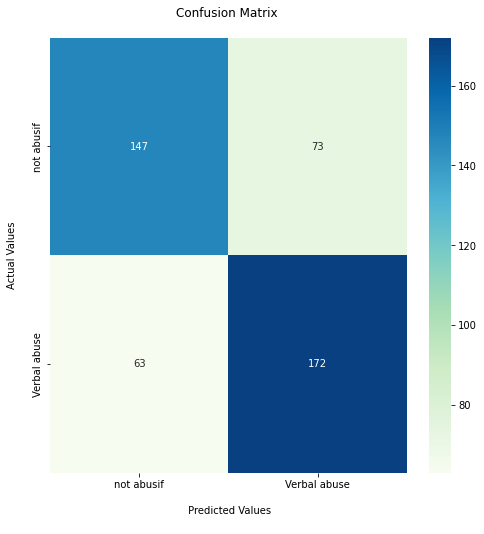

not abusif [0.08241314 0.91758686] not abusif
not abusif [0.34125992 0.65874008] Verbal abuse
Verbal abuse [0.82282379 0.17717621] Verbal abuse
not abusif [0.38411383 0.61588617] not abusif
Verbal abuse [0.65074289 0.34925711] Verbal abuse
Verbal abuse [0.58426618 0.41573382] not abusif
not abusif [0.02283249 0.97716751] not abusif
not abusif [0.1161143 0.8838857] not abusif
not abusif [0.18540349 0.81459651] not abusif
not abusif [0.40797233 0.59202767] not abusif
not abusif [0.35528555 0.64471445] not abusif
Verbal abuse [0.84807427 0.15192573] Verbal abuse
Verbal abuse [0.80523489 0.19476511] Verbal abuse
not abusif [0.23282353 0.76717647] not abusif
not abusif [0.18369377 0.81630623] not abusif
not abusif [0.16127486 0.83872514] Verbal abuse
not abusif [0.12216536 0.87783464] Verbal abuse
not abusif [0.28799935 0.71200065] not abusif
not abusif [0.46651161 0.53348839] not abusif
Verbal abuse [9.99105833e-01 8.94167335e-04] Verbal abuse
not abusif [0.34080402 0.65919598] not abusif


In [10]:
# Trying svm
from sklearn import svm
svm_model = svm.SVC(kernel='linear', C=1, probability=True).fit(X_train, y_train)
predicted_svm = svm_model.predict(X_test)
print(metrics.classification_report(y_test, predicted_svm))

# print probabilities
probs_svm = svm_model.predict_proba(X_test)

#confusion matrix
plt.figure(figsize=(8,8))
fx=sns.heatmap(metrics.confusion_matrix(y_test, predicted_svm), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'].unique())
fx.yaxis.set_ticklabels(data['label'].unique())
plt.show()

for i in range(len(probs_svm)):
    print(predicted_svm[i], probs_svm[i], y_test.iloc[i])

              precision    recall  f1-score   support

Verbal abuse       0.61      0.72      0.66       220
  not abusif       0.68      0.57      0.62       235

    accuracy                           0.64       455
   macro avg       0.65      0.64      0.64       455
weighted avg       0.65      0.64      0.64       455



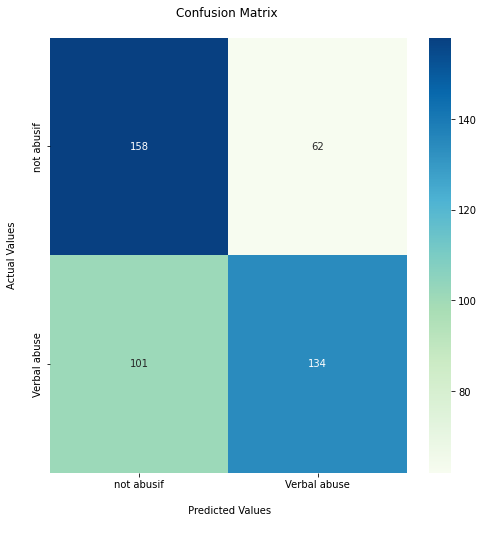

Verbal abuse [1. 0.] not abusif
Verbal abuse [1. 0.] Verbal abuse
Verbal abuse [1. 0.] Verbal abuse
not abusif [0. 1.] not abusif
not abusif [0. 1.] Verbal abuse
Verbal abuse [1. 0.] not abusif
not abusif [0. 1.] not abusif
not abusif [0. 1.] not abusif
not abusif [0. 1.] not abusif
Verbal abuse [1. 0.] not abusif
not abusif [0. 1.] not abusif
Verbal abuse [1. 0.] Verbal abuse
Verbal abuse [1. 0.] Verbal abuse
Verbal abuse [1. 0.] not abusif
Verbal abuse [1. 0.] not abusif
Verbal abuse [1. 0.] Verbal abuse
not abusif [0. 1.] Verbal abuse
not abusif [0. 1.] not abusif
not abusif [0. 1.] not abusif
Verbal abuse [1. 0.] Verbal abuse
Verbal abuse [1. 0.] not abusif
not abusif [0. 1.] not abusif
Verbal abuse [1. 0.] Verbal abuse
Verbal abuse [1. 0.] Verbal abuse
Verbal abuse [1. 0.] not abusif
Verbal abuse [1. 0.] Verbal abuse
not abusif [0. 1.] Verbal abuse
not abusif [0. 1.] not abusif
Verbal abuse [1. 0.] Verbal abuse
not abusif [0. 1.] Verbal abuse
Verbal abuse [1. 0.] not abusif
not ab

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the classifier
DTC = DecisionTreeClassifier().fit(X_train, y_train)

# Make predictions on the test data
predicted_DTC = DTC.predict(X_test)

print(metrics.classification_report(y_test, predicted_DTC))

# print probabilities
probs_dtc = DTC.predict_proba(X_test)

#confusion matrix
plt.figure(figsize=(8,8))
fx=sns.heatmap(metrics.confusion_matrix(y_test, predicted_DTC), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'].unique())
fx.yaxis.set_ticklabels(data['label'].unique())
plt.show()

for i in range(len(probs_svm)):
    print(predicted_DTC[i], probs_dtc[i], y_test.iloc[i])

              precision    recall  f1-score   support

Verbal abuse       0.62      0.79      0.69       220
  not abusif       0.73      0.55      0.63       235

    accuracy                           0.67       455
   macro avg       0.68      0.67      0.66       455
weighted avg       0.68      0.67      0.66       455



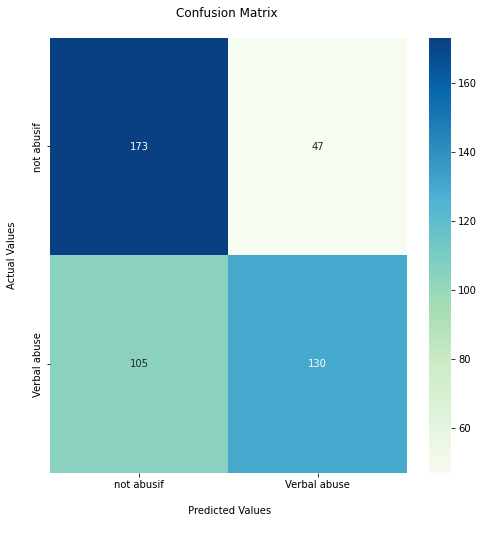

Verbal abuse [0.56 0.44] not abusif
Verbal abuse [0.63 0.37] Verbal abuse
Verbal abuse [0.83 0.17] Verbal abuse
not abusif [0.43 0.57] not abusif
Verbal abuse [0.6 0.4] Verbal abuse
Verbal abuse [0.73 0.27] not abusif
not abusif [0.17 0.83] not abusif
not abusif [0.26 0.74] not abusif
not abusif [0.32 0.68] not abusif
not abusif [0.44 0.56] not abusif
not abusif [0.46 0.54] not abusif
Verbal abuse [0.94 0.06] Verbal abuse
Verbal abuse [0.66 0.34] Verbal abuse
Verbal abuse [0.63 0.37] not abusif
Verbal abuse [0.58 0.42] not abusif
not abusif [0.22 0.78] Verbal abuse
not abusif [0.47 0.53] Verbal abuse
not abusif [0.38 0.62] not abusif
Verbal abuse [0.51 0.49] not abusif
Verbal abuse [0.91 0.09] Verbal abuse
not abusif [0.34 0.66] not abusif
not abusif [0.41166667 0.58833333] not abusif
not abusif [0.47 0.53] Verbal abuse
Verbal abuse [0.706 0.294] Verbal abuse
Verbal abuse [0.8 0.2] not abusif
Verbal abuse [0.86 0.14] Verbal abuse
Verbal abuse [0.595 0.405] Verbal abuse
not abusif [0.49

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
RFC = RandomForestClassifier().fit(X_train, y_train)
predicted_RFC = RFC.predict(X_test)
print(metrics.classification_report(y_test, predicted_RFC))
# Make predictions on the test data
probs_rfc = RFC.predict_proba(X_test)

#confusion matrix
plt.figure(figsize=(8,8))
fx=sns.heatmap(metrics.confusion_matrix(y_test, predicted_RFC), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'].unique())
fx.yaxis.set_ticklabels(data['label'].unique())
plt.show()

for i in range(len(probs_svm)):
    print(predicted_RFC[i], probs_rfc[i], y_test.iloc[i])

              precision    recall  f1-score   support

Verbal abuse       0.75      0.67      0.71       220
  not abusif       0.72      0.79      0.75       235

    accuracy                           0.73       455
   macro avg       0.73      0.73      0.73       455
weighted avg       0.73      0.73      0.73       455



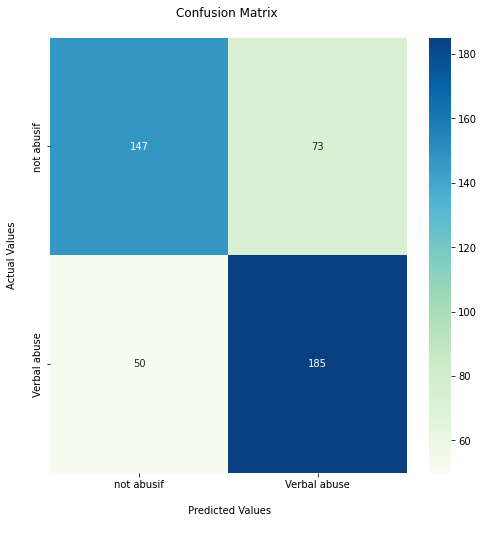

not abusif [0.15295056 0.84704944] not abusif
not abusif [0.45246375 0.54753625] Verbal abuse
Verbal abuse [0.78319654 0.21680346] Verbal abuse
not abusif [0.3291686 0.6708314] not abusif
Verbal abuse [0.56332258 0.43667742] Verbal abuse
Verbal abuse [0.64491873 0.35508127] not abusif
not abusif [0.05387376 0.94612624] not abusif
not abusif [0.18814672 0.81185328] not abusif
not abusif [0.13490124 0.86509876] not abusif
not abusif [0.3935717 0.6064283] not abusif
not abusif [0.33968975 0.66031025] not abusif
Verbal abuse [0.81926053 0.18073947] Verbal abuse
Verbal abuse [0.85166875 0.14833125] Verbal abuse
not abusif [0.42765878 0.57234122] not abusif
not abusif [0.25774229 0.74225771] not abusif
not abusif [0.16921166 0.83078834] Verbal abuse
not abusif [0.16799481 0.83200519] Verbal abuse
not abusif [0.24546287 0.75453713] not abusif
not abusif [0.5 0.5] not abusif
Verbal abuse [9.99219949e-01 7.80050687e-04] Verbal abuse
not abusif [0.3080474 0.6919526] not abusif
not abusif [0.1477

In [13]:
from sklearn.svm import SVC

# Initialize the classifier
SVC = SVC(probability=True).fit(X_train, y_train)
predicted_SVC = SVC.predict(X_test)
print(metrics.classification_report(y_test, predicted_SVC))
# Make predictions on the test data
probs_svc = SVC.predict_proba(X_test)

#confusion matrix
plt.figure(figsize=(8,8))
fx=sns.heatmap(metrics.confusion_matrix(y_test, predicted_SVC), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'].unique())
fx.yaxis.set_ticklabels(data['label'].unique())
plt.show()

for i in range(len(probs_svm)):
    print(predicted_SVC[i], probs_svc[i], y_test.iloc[i])

In [14]:
# # balance the data
# data = data.groupby('label').apply(lambda x: x.sample(1305, replace=True)).reset_index(drop=True)

# data.label.value_counts()

## LSTM

In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



In [16]:
data

,text,label
1,انو غريب يوجعك راسك القواتجيه عاده بيكونو بلا راس,not abusif
2,طاءفي روح اسال اهل قانا وهني بخبروك,not abusif
4,الفلسطينيين واللبنانين والشاميين لكان انتو لليوم تشربوا بول البعير تاكلون بصحن وتبزقون منو,not abusif
7,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,not abusif
9,هيدي مش وزيره هيدي شيطان الحكومه عاملي ال عمليه تجميل وبعدا بشعه محلا المسخ,not abusif
...,...,...
2447,مرتزق وبتفلسف الحكومه حزب وغبر معروف غريب عابش التسول تعال صنعا اذا تريد فلوس,Verbal abuse
2449,بوزبال,Verbal abuse
2454,كذب خنزيره حسبي الله ونعم الوكيل فيكم اللهم احفظ مصر شركم تحيا مصر رغم انف الحاقدين,Verbal abuse
2455,الناس غادين معاه بنيتهم شلاهبي ولكين الحق غادي يبان,Verbal abuse


In [17]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15093 unique tokens.


In [18]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (2272, 250)


In [19]:
Y = pd.get_dummies(data['label']).values
print('Shape of label tensor:', Y.shape)
Y

# encodedict = {'not abusif': 0, 'Verbal abuse': 1}
# Y = np.array([encodedict[item] for item in data['label']])
# print('Shape of label tensor:', Y.shape)
# Y

Shape of label tensor: (2272, 2)


array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1704, 250) (1704, 2)
(568, 250) (568, 2)


In [21]:
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(2, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# from keras.layers import BatchNormalization, GlobalMaxPooling1D
# lstm = Sequential()
# lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# lstm.add(BatchNormalization())
# lstm.add(LSTM(100, return_sequences=True))
# lstm.add(LSTM(100, return_sequences=True))
# lstm.add(LSTM(100))
# lstm.add(Dense(100, activation='relu'))
# lstm.add(Dropout(0.5))
# lstm.add(Dense(2, activation='sigmoid'))
# lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(lstm.summary())

# LSTM model
lstm = Sequential()
lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
lstm.add(LSTM(256, input_shape = (len(word_index)+1, 300), return_sequences=True))
lstm.add(Dropout(0.1))
lstm.add(LSTM(128))
lstm.add(Dense(16))
lstm.add(Dense(2, activation = 'sigmoid'))
lstm.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
lstm.summary()

2023-01-08 00:36:06.347200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 00:36:06.351097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 00:36:06.351838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 00:36:06.354135: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 300)          15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 250, 256)          570368    
_________________________________________________________________
dropout (Dropout)            (None, 250, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 15,769,586
Trainable params: 15,769,586
Non-trainable params: 0
____________________________________________

In [22]:
epochs = 40
batch_size = 64

history = lstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.25,callbacks=[EarlyStopping(monitor='val_loss', patience=25, min_delta=0.0001)])

Epoch 1/40


2023-01-08 00:36:09.650180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-08 00:36:13.381268: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


20/20 [==============================] - 7s 86ms/step - loss: 0.6868 - accuracy: 0.5751 - val_loss: 0.6841 - val_accuracy: 0.5446
Epoch 2/40
20/20 [==============================] - 1s 54ms/step - loss: 0.5262 - accuracy: 0.7340 - val_loss: 0.6559 - val_accuracy: 0.6714
Epoch 3/40
20/20 [==============================] - 1s 54ms/step - loss: 0.1337 - accuracy: 0.9531 - val_loss: 1.3745 - val_accuracy: 0.6526
Epoch 4/40
20/20 [==============================] - 1s 54ms/step - loss: 0.0305 - accuracy: 0.9914 - val_loss: 1.3910 - val_accuracy: 0.6315
Epoch 5/40
20/20 [==============================] - 1s 55ms/step - loss: 0.0118 - accuracy: 0.9984 - val_loss: 1.4919 - val_accuracy: 0.6455
Epoch 6/40
20/20 [==============================] - 1s 55ms/step - loss: 0.0271 - accuracy: 0.9914 - val_loss: 1.0690 - val_accuracy: 0.6291
Epoch 7/40
20/20 [==============================] - 1s 56ms/step - loss: 0.0190 - accuracy: 0.9969 - val_loss: 1.1350 - val_accuracy: 0.6408
Epoch 8/40
20/20 [======

In [23]:
X_test.shape,Y_test.shape

((568, 250), (568, 2))

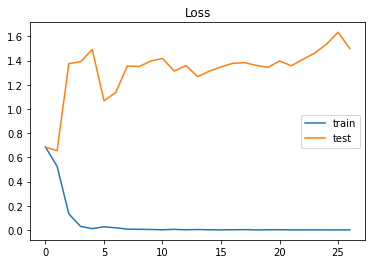

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

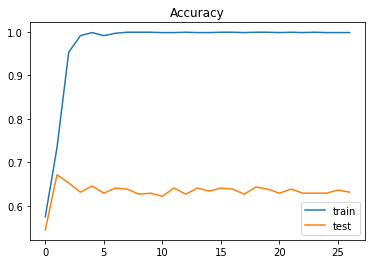

In [25]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [26]:
accr = lstm.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

18/18 [==============================] - 0s 14ms/step - loss: 1.7552 - accuracy: 0.6250
Test set
  Loss: 1.755
  Accuracy: 0.625


In [27]:
predicted_lstm = lstm.predict(X_test)
#print(predicted_lstm.shape)
predicted_lstm

array([[9.2172933e-01, 7.0852801e-02],
       [9.7995090e-01, 1.9598266e-02],
       [9.7734559e-01, 2.1142464e-02],
       ...,
       [1.1910933e-01, 8.7192398e-01],
       [2.8564008e-07, 9.9999976e-01],
       [1.3364325e-01, 8.2240003e-01]], dtype=float32)

In [28]:
# #confusion matrix
# plt.figure(figsize=(8,8))
# fx=sns.heatmap(metrics.confusion_matrix(Y_test, predicted_lstm), annot=True, fmt="d",cmap="GnBu")
# fx.set_title('Confusion Matrix \n');
# fx.set_xlabel('\n Predicted Values\n')
# fx.set_ylabel('Actual Values\n');
# fx.xaxis.set_ticklabels(data['label'].unique())
# fx.yaxis.set_ticklabels(data['label'].unique())
# plt.show()

# for i in range(len(probs_svm)):
#     print(predicted_lstm[i],Y_test.iloc[i])

In [29]:
labels = ['Verbal abuse','not abusif']
pred_lstm=[]
for pred in predicted_lstm:
    print(pred, labels[np.argmax(pred)])
    pred_lstm.append(labels[np.argmax(pred)])
pred_lstm=np.array(pred_lstm)


[0.9217293 0.0708528] Verbal abuse
[0.9799509  0.01959827] Verbal abuse
[0.9773456  0.02114246] Verbal abuse
[0.33009908 0.64422   ] not abusif
[0.08370246 0.8852143 ] not abusif
[0.410646  0.5647894] not abusif
[1.2355766e-05 9.9998939e-01] not abusif
[8.778872e-04 9.991611e-01] not abusif
[5.726593e-04 9.994148e-01] not abusif
[0.44285166 0.43977877] Verbal abuse
[0.02484082 0.98525465] not abusif
[0.99550205 0.004477  ] Verbal abuse
[9.9997711e-01 2.0194491e-05] Verbal abuse
[1.12053596e-04 9.99907374e-01] not abusif
[0.01501947 0.98152393] not abusif
[1.7344259e-05 9.9998426e-01] not abusif
[0.05008976 0.96573055] not abusif
[0.89926314 0.08806638] Verbal abuse
[0.17480724 0.72126365] not abusif
[0.9990133  0.00151898] Verbal abuse
[0.9408868  0.04578846] Verbal abuse
[0.12103505 0.90751874] not abusif
[0.03466775 0.96096486] not abusif
[0.07596292 0.9381838 ] not abusif
[9.9992108e-01 8.7145105e-05] Verbal abuse
[9.997384e-01 2.209242e-04] Verbal abuse
[0.758561   0.21419849] Verb

In [30]:
new_complaint = ['ولك يا حمار اسكت و ريحنا منك ولو ها المرة بس']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = lstm.predict(padded)
labels = ['verbal abuse','none']
print(pred, labels[np.argmax(pred)])

[[9.9998105e-01 1.5083551e-05]] verbal abuse


## Arabert

### Preprocessing and Cleaning

In [31]:
def remove_hashtag(df, col = 'text'):
    for letter in r'#.][!XR':
        df[col] = df[col].astype(str).str.replace(letter,'', regex=True)
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
from nltk.stem.isri import ISRIStemmer
import re

stemmer = ISRIStemmer()
def processDocument(doc, stemmer): 

    #Replace @username with empty string
    doc = re.sub(r'@[^\s]+', ' ', doc)
    doc = re.sub(r'_', ' ', doc)
    doc = re.sub(r'\n', ' ', doc)
    doc = re.sub(r'\r', ' ', doc)
    doc = re.sub(r':///', ' ', doc)
    doc = re.sub(r'///:', ' ', doc)
    doc = re.sub(r'مستخدم@', ' ', doc)
    doc = re.sub(r'[a-z,A-Z]', ' ', doc)
    doc = re.sub(r'\d', '', doc)
    #Convert www.* or https?://* to " "
    doc = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',doc)
    #Replace #word with word
    doc = re.sub(r'#([^\s]+)', r'\1', doc)
    # remove punctuations
    # normalize the tweet
#     doc= normalize_arabic(doc)
    # remove repeated letters
#     doc=remove_repeating_char(doc)
    #stemming
#     doc = stemmer.stem(doc)
   
    return doc

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


In [32]:
import pyarabic.araby as araby
frame=annotated_data
frame=frame.drop_duplicates()
remove_hashtag(frame)
frame["text"] = frame['text'].apply(lambda x: araby.strip_diacritics(x))
frame["text"] = frame['text'].apply(lambda x: normalize_arabic(x))
frame["text"] = frame['text'].apply(lambda x: processDocument(x, stemmer))
frame["text"] = frame['text'].apply(lambda x: deEmojify(x))

frame

,text,label
0,البطل قاتل وجاذف بحياته لتحيا انت واطي عيب الشوم,Verbal abuse
1,انو غريب يوجعك راسك القواتجيه عاده بيكونو بلا راس,Racism
2,طاءفي روح اسال اهل قانا وهني بخبروك,Racism
3,غرد الجحش وظن باءنه حصانا تتكلم العوني بموضوعيه فيرد كبهيم حقير جربان اصله,Verbal abuse
4,الفلسطينيين واللبنانين والشاميين لكان انتو لليوم تشربوا بول البعير تاكلون بصحن وتبزقون منو,Racism
...,...,...
2486,اله اينعل ربك,religion_off
2487,شيطان,religion_off
2488,يهودي،,religion_off
2489,تا فينو الله؟؟ - الالحاد,religion_off


In [33]:
# select label racism
abusif = frame[frame['label'] == 'Verbal abuse']
# delete label racism from df
not_abusif = frame[frame['label'] != 'Verbal abuse']
not_abusif = not_abusif.iloc[:1136]
# concat abusif and df
data = pd.concat([not_abusif, abusif])
# rename label diffrent than abusif to 'not abusif'
data['label'] = data['label'].apply(lambda x: 'none' if x != 'Verbal abuse' else x)
data


,text,label
1,انو غريب يوجعك راسك القواتجيه عاده بيكونو بلا راس,none
2,طاءفي روح اسال اهل قانا وهني بخبروك,none
4,الفلسطينيين واللبنانين والشاميين لكان انتو لليوم تشربوا بول البعير تاكلون بصحن وتبزقون منو,none
7,مشكلتك بوق بانك سلبي بسليقتك وتحب ان تهاجم الاخرين تظهر جهه وتنفذ يطلبه منك مشغليكالمهم,none
9,هيدي مش وزيره هيدي شيطان الحكومه عاملي ال عمليه تجميل وبعدا بشعه محلا المسخ,none
...,...,...
2447,مرتزق وبتفلسف ؟ ليس في الحكومه ولا حزب وغبر معروف غريب عابش علي التسولتعال صنعا اذا تريد فلوس,Verbal abuse
2449,بوزبال,Verbal abuse
2454,كذب يا خنزيره حسبي الله ونعم الوكيل فيكم اللهم احفظ مصر من شركم تحيا مصر رغم انف الحاقدين ✌,Verbal abuse
2455,الناس غادين معاه بنيتهم وهو شلاهبي ولكين الحق غادي يبان,Verbal abuse


In [34]:
# # Import necessary libraries
# from transformers import AutoTokenizer, AutoModel
# import numpy as np
# from keras.layers import Embedding, LSTM, Dense, Dropout
# from keras.preprocessing import sequence
# from sklearn.preprocessing import LabelBinarizer
# from keras.models import Sequential

# # Load the Arabic comments dataset
# X =frame['text'] # list of comments
# #X = list(map(str, X))
# y =frame['label'] # list of labels (abusive or not abusive)

# # Preprocess the data by tokenizing the comments and converting the tokens to Arabert word embeddings
# tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
# model = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv02")
# sequences = tokenizer(X, padding=True, return_tensors="pt").input_ids
# X = model(sequences)[0][:, 0, :].numpy()

# # Convert the labels to a binary class matrix
# lb = LabelBinarizer()
# y = lb.fit_transform(y)

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))
# model.add(Dense(2, activation='sigmoid'))

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model on the training set
# model.fit(X_train, y_train, batch_size=64, epochs=5)

# # Evaluate the model on the test set
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))


In [35]:
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [37]:
import joblib
train, val = train_test_split(data[['label','text']], test_size=0.2, random_state=42)


lbl_enc = LabelEncoder()
train.loc[:,"label"] = lbl_enc.fit_transform(train["label"])
val.loc[:,"label"] = lbl_enc.fit_transform(val["label"])
joblib.dump(lbl_enc,"label_encoder.pkl")
train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)
lbl_enc.classes_

['label_encoder.pkl']

array(['Verbal abuse', 'none'], dtype=object)

In [38]:
train['label'].value_counts(),val['label'].value_counts()

(1    904
 0    898
 Name: label, dtype: int64,
 1    232
 0    219
 Name: label, dtype: int64)

In [39]:
class ArabicDataset(Dataset):
    def __init__(self,data,max_len,model_type="Mini"):
        super().__init__()
        self.labels = data["label"].values
        self.texts = data["text"].values
        self.max_len = max_len
        model = {"Mini": "asafaya/bert-mini-arabic",
                "Medium": "asafaya/bert-medium-arabic",
                "Base": "asafaya/bert-base-arabic",
                "Large": "asafaya/bert-large-arabic"}
        self.tokenizer = AutoTokenizer.from_pretrained(model[model_type])
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,idx):
        text = " ".join(self.texts[idx].split())
        label = self.labels[idx]
        inputs = self.tokenizer(text,padding='max_length',
                                max_length=self.max_len,truncation=True,return_tensors="pt")
        #input_ids,token_type_ids,attention_mask
        return {
            "inputs":{"input_ids":inputs["input_ids"][0],
                      "token_type_ids":inputs["token_type_ids"][0],
                      "attention_mask":inputs["attention_mask"][0],
                     },
            "labels": torch.tensor(label,dtype=torch.long) 
        }

In [40]:
class ArabicBertModel(pl.LightningModule):
    def __init__(self,model_type="Mini"):
        super().__init__()
        model = {"Mini": ("asafaya/bert-mini-arabic",256),
                "Medium": ("asafaya/bert-medium-arabic",512),
                "Base": ("asafaya/bert-base-arabic",768),
                "Large": ("asafaya/bert-large-arabic",1024)}
        self.bert_model = AutoModel.from_pretrained(model[model_type][0])
        self.fc = nn.Linear(model[model_type][1],18)
    
    def forward(self,inputs):
        out = self.bert_model(**inputs)#inputs["input_ids"],inputs["token_type_ids"],inputs["attention_mask"])
        pooler = out[1]
        out = self.fc(pooler)
        return out
    
    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)
    
    def criterion(self,output,target):
        return nn.CrossEntropyLoss()(output,target)
    
    #TODO: adding metrics
    def training_step(self,batch,batch_idx):
        x,y = batch["inputs"],batch["labels"]
        out = self(x)
        loss = self.criterion(out,y)
        return loss
    
    def validation_step(self,batch,batch_idx):
        x,y = batch["inputs"],batch["labels"]
        out = self(x)
        loss = self.criterion(out,y)
        return loss

In [41]:
class ArabicDataModule(pl.LightningDataModule):
    def __init__(self,train_path,val_path,batch_size=12,max_len=100,model_type="Mini"):
        super().__init__()
        self.train_path,self.val_path= train_path,val_path
        self.batch_size = batch_size
        self.max_len = max_len
        self.model_type = model_type
    
    def setup(self,stage=None):
        train = pd.read_csv(self.train_path)
        val = pd.read_csv(self.val_path)
        self.train_dataset = ArabicDataset(data=train,max_len=self.max_len,model_type=self.model_type)
        self.val_dataset = ArabicDataset(data=val,max_len=self.max_len,model_type=self.model_type)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=4)

### callbacks

In [42]:
import torch
from torch import nn,optim

from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
#TODO: getting different models sizes results
MODEL_TYPE = "Medium"
dm = ArabicDataModule(train_path="./train.csv",
                val_path = "./val.csv",
                batch_size=128,max_len=60 , model_type=MODEL_TYPE)

model = ArabicBertModel(model_type=MODEL_TYPE)
#trainer = pl.Trainer(accelerator='gpu', devices=1,max_epochs=20, default_root_dir='.')
trainer = pl.Trainer(accelerator='gpu',max_epochs=20, devices=1, default_root_dir='.')
trainer.fit(model,dm)

Some weights of the model checkpoint at asafaya/bert-medium-arabic were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preds = []
real_values = []

load = ArabicDataModule(train_path="./train.csv",
                           val_path = "./val.csv",
                batch_size=512,max_len=60)
load.setup()
train_dataloader = load.train_dataloader()

progress_bar = tqdm(range(len(train_dataloader)))

model.eval()
for batch in train_dataloader:    
    x,y = batch["inputs"],batch["labels"]
    inp = {k: v.to(device) for k, v in x.items()}
    
    with torch.no_grad():
        outputs = model(inp)

    predictions = torch.argmax(outputs, dim=-1)
    
    preds.extend(predictions)
    real_values.extend(y)

    progress_bar.update()
    
preds = torch.stack(preds).cpu()
real_values = torch.stack(real_values).cpu()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(real_values, preds, target_names=lbl_enc.classes_))

In [ ]:
import sklearn.metrics as metrics

plt.figure(figsize=(16,10))
fx=sns.heatmap(metrics.confusion_matrix(real_values, preds), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'])
fx.yaxis.set_ticklabels(data['label'])
plt.show()

In [ ]:
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preds = []
real_values = []

load = ArabicDataModule(train_path="./train.csv",
                           val_path = "./val.csv",
                batch_size=512,max_len=60)
load.setup()
test_dataloader = load.val_dataloader()

progress_bar = tqdm(range(len(test_dataloader)))

model.eval()
for batch in test_dataloader:    
    x,y = batch["inputs"],batch["labels"]
    inp = {k: v.to(device) for k, v in x.items()}
    
    with torch.no_grad():
        outputs = model(inp)

    predictions = torch.argmax(outputs, dim=-1)
    
    preds.extend(predictions)
    real_values.extend(y)

    progress_bar.update()
    
preds = torch.stack(preds).cpu()
real_values = torch.stack(real_values).cpu()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(real_values, preds, target_names=lbl_enc.classes_))

In [ ]:
import sklearn.metrics as metrics

plt.figure(figsize=(16,10))
fx=sns.heatmap(metrics.confusion_matrix(real_values, preds), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'])
fx.yaxis.set_ticklabels(data['label'])
plt.show()

In [ ]:
import pickle

# Save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)